In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img
from glob import glob
import os
from matplotlib import pyplot as plt

%matplotlib inline

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
files = glob('../data/processed/mos_numpy/mosaic_*')
len(files)

207

In [277]:
f = files[15]

df = pd.read_csv(f, header=None)

df

,0,1,2,3,4,5,6,7
0,deb1b058f8,NaN,02658f5ae3,b82cd81273,NaN,943754ba03,3022a2d122,754f34301c
1,f01741e3fb,389139a9d0,ceedc60808,51c4fbfe63,71ce93a7b7,01b134167c,9fe905c12d,de2ce9bf28
2,522bfc0c1b,NaN,cc18f94210,22b0703aa1,68bad6a787,e594ef45fc,811fb98143,9a171b49a9
3,e8f48a2038,bcabfde62b,0703a8437b,69253f7efc,9a14689f82,f5865bd6ff,b35a524585,92b23cfe90
4,b212dd2177,10c3458a28,0c43ec36f9,47729d4ee5,ad7d11a9ce,343a049d60,643a1fb9c4,6a3f8feaea
5,NaN,82904b406b,79fed5a697,59d6fd86f3,2ab5284049,467f13c5c8,55b7d18492,NaN
6,NaN,07c3553ef7,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import pickle
# loading testset prediction
with open('prediction/1008_v1_seed_snapshot_cycle_blending_1_2_3_4_5_6.pkl', 'rb') as f:
    preds_test_blend = pickle.load(f)

#
img_ids = [f.split('/')[-1].split('.')[0] for f in glob('../data/raw/test_images/images/*.png')]

N = 18

unpad_pred_dict = {}
for i, img_id in enumerate(img_ids):
    unpad_pred_dict[img_id] = np.round(preds_test_blend[i] > N)

In [14]:
# loading trainset pred
with open('../data/processed/trainset_pred1017.pkl', 'rb') as f:
    train_pred = pickle.load(f)

In [451]:
def empty_img():
    img_arr = np.clip(np.fliplr(np.eye(101)) + np.eye(101), a_min=0, a_max=1)
    img_arr[0] = 1
    img_arr[100] = 1
    img_arr[:, 0] = 1
    img_arr[:, 100] = 1
    return img_arr

def load_image(img_id, mode='image'):
    """
    mode: 'image', 'mask'
    """
    if mode=='image':
        in_train = "../data/raw/train_images/images/%s.png"%img_id
        in_test = "../data/raw/test_images/images/%s.png"%img_id
    elif mode=='mask':
        in_train = "../data/raw/train_images/masks/%s.png"%img_id
        in_test = "../data/raw/test_images/masks/%s.png"%img_id
    elif mode=='pred':
        try:
            img_arr = unpad_pred_dict[img_id]
        except:
            try:
                img_arr = train_pred[img_id]
            except:
                img_arr = empty_img()
        return img_arr
    f = in_train if os.path.isfile(in_train) else in_test
    try:
        img_arr = np.array(load_img(f, color_mode = "grayscale")) / 255
    except:
        # nan
        #print('missing file: ', f)
        img_arr = empty_img()
    return img_arr

def combine_images(df, mode='image'):
    r,c = df.shape
    fig=plt.figure(figsize=(10, 10))
    
    img_col = None
    for i in df.index:
        img_row = None
        for j in df.columns:
            img_id = df.loc[i, j]
            img_arr = load_image(img_id, mode)
            if img_row is None:
                img_row = img_arr
            else:
                img_row = np.concatenate((img_row, img_arr), axis=1)
        if img_col is None:
            img_col = img_row
        else:
            img_col = np.concatenate((img_col, img_row), axis=0)
            #
            #ax = fig.add_subplot(r, c, i*c+j+1)
            #plt.imshow(img_arr, cmap='binary')
    plt.imshow(img_col, cmap='binary')
    return img_col

#----------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------
def load_image2(img_id):
    """
    mode: 'image', 'mask'
    """
    if str(img_id) == 'nan':
        return empty_img()
    in_train = "../data/raw/train_images/masks/%s.png"%img_id
    in_test = "../data/raw/test_images/masks/%s.png"%img_id
    f = in_train if os.path.isfile(in_train) else in_test
    try:
        img_arr = np.array(load_img(in_train, color_mode = "grayscale")) / 255 if os.path.isfile(in_train) \
                                                                        else unpad_pred_dict[img_id]
    except:
        img_arr = empty_img()
    return img_arr

def is_in_train(img_id):
    if str(img_id) == 'nan':
        return None
    in_train = "../data/raw/train_images/masks/%s.png"%img_id
    #in_test = "../data/raw/test_images/masks/%s.png"%img_id
    return True if os.path.isfile(in_train) else False


def find_train_vertical(df):
    train_vertical = []
    for i in df.index:
        for j in df.columns:
            img_id = df.loc[i, j]
            img_arr = load_image2(img_id)
            if is_vertical(img_arr, x_threshold=20, y_threshold=90) and is_in_train(img_id)==True:
                #print('is_train: ', i, j, img_id)
                train_vertical.append([i, j])
    return train_vertical

def is_vertical(img, x_threshold=10, y_threshold=90):
    if img.mean()==0:
        return False
    img = find_boundaries(img.astype(np.uint8), connectivity=1).astype(np.uint8)
    y, x = np.where(img==1)
    if len(x) < 50 or len(y) < 50:
        return False
    if y.max()-y.min()>y_threshold and x.max()-x.min()<x_threshold:#10
        return True
    else:
        median = np.median(x)
        x0 = x[x>median]
        y0 = y[x>median]
        x1 = x[x<median]
        y1 = y[x<median]
        if len(x0)<50 or len(x1)<50:
            return False
        if y0.max()-y0.min()>y_threshold and x0.max()-x0.min()<x_threshold and \
        y1.max()-y1.min()>y_threshold and x1.max()-x1.min()<x_threshold:
            return True
        return False

def mod_test_mask(df, train_vertical):
    mod_output = {}
    
    for i,j in train_vertical:
        train_vertical_img_id = df.loc[i, j]
        train_vertical_img_arr = load_image2(train_vertical_img_id)
        try:
            # test mask above the train_vertical
            test_img_id = df.loc[i-1, j]
            if is_in_train(test_img_id)==False:
                mod_output[test_img_id] = train_vertical_img_arr
        except:
            pass
        try:
            # test mask below the train_vertical
            test_img_id = df.loc[i+1, j]
            if is_in_train(test_img_id)==False:
                mod_output[test_img_id] = train_vertical_img_arr#test_img_id, train_vertical_img_id
        except:
            pass
    return mod_output

def mod_test_mask_all(files):
    mod_output_all = {}
    for f in files:
        df = pd.read_csv(f, header=None)
        train_vertical = find_train_vertical(df)
        mod_output = mod_test_mask(df, train_vertical)
        mod_output_all.update(mod_output)
    return mod_output_all

def count_train_vertical(files):
    count = 0
    for f in files:
        df = pd.read_csv(f, header=None)
        train_vertical = find_train_vertical(df)
        #print(len(train_vertical))
        count += len(train_vertical)
    return count

In [452]:
mod_output_all = mod_test_mask_all(files)
#count = count_train_vertical(files)


In [453]:
len(mod_output_all.keys())

219

In [454]:
# save
with open('../data/processed/postprocess_vertical20.pkl', 'wb') as f:
    pickle.dump(mod_output_all, f, protocol=4)

In [448]:
mod_output_all.keys()

dict_keys(['644d224e9c', 'ee98738f1f', '044d6800ff', '221a6117a2', 'c6a614c6fb', 'ee5113e6a0', '51ad12b135', 'ba3558504f', '9765869d24', 'a765cd6aab', 'ff47f2a6f2', 'a99b61c527', '2ecd04a9f8', '724541cf3b', 'e4ce609688', '0fa88fc811', '9c276c8606', '81575289eb', '59f63d1a95', '349516c6c0', '6f48dd2861', 'a4a5eca0c8', 'feaae39fc4', '52449a1c2a', '848fcb838e', 'c0df1c6bc5', '3b69920d03', '67e8e9f5a2', 'fe6b152962', '18f3cb6bd1', 'c37b8373f3', 'a93060eb0d', '4d2778b117', '9163f15e89', '73d6a58df1', '34003990cc', 'f6b8bf64b4', 'd36a3ca700', '80693d458f', 'c32590b06f', 'b5469f2eb9', '1ac1e18079', 'dbf16358a4', 'e83c7943f9', '3548f9bbca', '292ea3b61f', 'c5cc962173', 'bf98f3e3a7', 'c5f64bb650', '8676b531a3', 'aa082095e7', '6b3478573c', '14f25502c5', 'b37ebb4c18', '2ad5cb95c8', '7d187bf4bb', '53d4c8a52c', '833ff7ed7e', '11005c0470', '32fe997af3', '94857fe622', '518b6d0f17', 'cbd043c3b0', 'cc46103f98', 'c49ef24cd2', '0521e30a6c', 'eaaa014bcd', 'ece1494d81', 'cec3aace1e', 'd5dec361aa', '8aa2cf1e

In [449]:
img_id = '3709acd3d8'
in_train = "../data/raw/train_images/masks/%s.png"%img_id

img_arr = np.array(load_img(in_train, color_mode = "grayscale")) / 255
plt.imshow(img_arr.astype(np.uint8), cmap='binary')

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/train_images/masks/3709acd3d8.png'

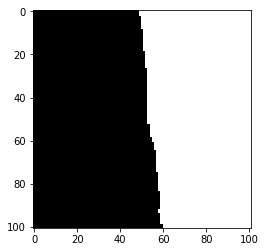

In [257]:
img_id = 'e5a61707cf'
img_arr = unpad_pred_dict[img_id]

plt.imshow(img_arr.astype(np.uint8), cmap='binary')

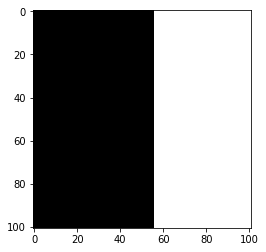

In [258]:
img_id = 'e5a61707cf'
img_arr = mod_output_all[img_id]

plt.imshow(img_arr.astype(np.uint8), cmap='binary')

In [439]:
f = files[68]

df = pd.read_csv(f, header=None)

df

,0,1,2,3,4,5
0,9bd349312c,4bd87bd3da,dc4a1c9a30,3e1b6580f5,c593c662f1,a003c71571
1,28948eeb9c,NaN,bba083d347,b749a000ea,1cf33ec55a,3fbe62aa50
2,e97033b42c,NaN,9159c5f8fe,da41e9ed21,e47c5d83fc,5bef437307
3,a971d2ae53,aeba5383e4,9a804d3e93,4bbe1afbc2,4b72e35b8b,3cffb3227b
4,f13f682676,8676b531a3,9ad15b2d25,20345ad292,aa082095e7,1dcf541ad8
5,cc6abe337d,NaN,aa2ab180cd,4e583649f3,f6e87c1458,7b19f5eb71
6,5489a9e706,a77029244a,c899bb9da4,1d23853728,6b3478573c,db17867b19
7,e73532b450,ac1c1262a0,a77f69692a,79ad96357c,4db87ce39b,NaN


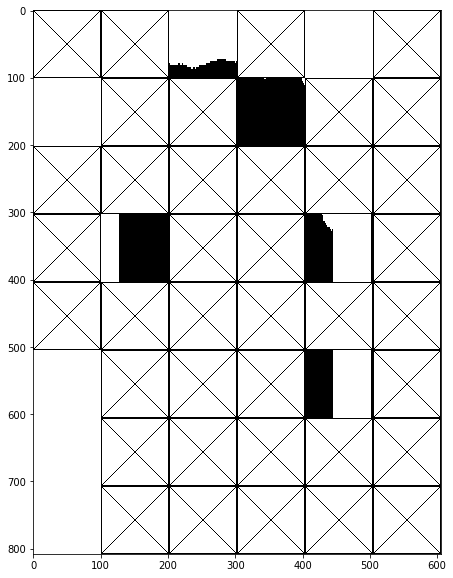

In [440]:
#img_col = combine_images(df, mode='image')
mask_col = combine_images(df, mode='mask')
#pred_col = combine_images(df, mode='pred')

## check single image

In [419]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b97918ac08,ad19d4e20c,376b6b7e94
1,08f3e1580b,NaN,c7c3a8a806,1ee82dabee,4071dd4858,NaN,10dc83d62f,46c1a0e9a3,98c97825f1,6ba0601416,69ab424098,1dbc694c5d
2,be542946f5,b345b1f290,88efb73723,41bbbc3c6a,0e16439e05,NaN,27ed8e3d5f,f32a360c8b,NaN,NaN,7d51af6ef3,c1b3a9912c
3,2bd6da4508,9f4471dcd6,a4990e5d39,b0e3178d6f,2efa022d01,NaN,dea0a56bab,NaN,a8e62d2504,65fe1a0efc,c455f7be1b,280911f6fd
4,7d596c01eb,6d34f414ed,d36a3ca700,9881925fc5,048763f628,3ab7b7d831,bc6b14c9d3,71f7425387,c32590b06f,36841d78ba,NaN,4a12baccc4
5,aede306d15,ebbd2ea275,a9ee40cf0d,55689d22ea,5468ed796d,0ca07a2b06,280dcd0b2d,f6b8bf64b4,53e17edd83,f9467f033a,6d8b46c501,524f01dd79
6,NaN,05bf647e6d,80693d458f,34acb105f7,8b71ac9863,cda1d37159,c3cb500dfb,235fce1c1e,b5469f2eb9,c1ed7e8344,9ac1f214d8,5f487741b7
7,4d6ef1a9bb,9afa3dea27,a3f984c72f,82385cd8e9,c5d6fe7b88,40a6d01026,9556d5ea0a,cb707b00e6,71f7ef5864,3116a9d54c,029dd6f51f,NaN


In [420]:
#img = unpad_pred_dict['ebbd2ea275'].astype(np.uint8)
img = train_pred['a9ee40cf0d'].astype(np.uint8)

img

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

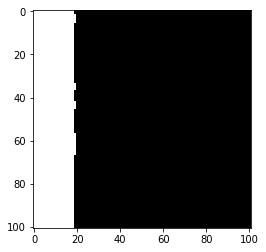

In [421]:
plt.imshow(img, cmap='binary')

## find boundary

In [9]:
from skimage.segmentation import find_boundaries

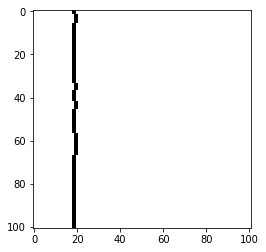

In [422]:
_img = find_boundaries(img, connectivity=1).astype(np.uint8)

#_img = smooth_mask(_img, kernel_size=1)

plt.imshow(_img, cmap='binary')

In [21]:
#plt.imshow(np.flipud(_img), cmap='binary')

In [398]:
def is_vertical(img, x_threshold=10, y_threshold=90):
    if img.mean()==0:
        return False
    img = find_boundaries(img.astype(np.uint8), connectivity=1).astype(np.uint8)
    y, x = np.where(img==1)
    if len(x) == 0 or len(y) == 0:
        return False
    if y.max()-y.min()>y_threshold and x.max()-x.min()<x_threshold:#10
        return True
    else:
        median = np.median(x)
        x0 = x[x>median]
        y0 = y[x>median]
        x1 = x[x<median]
        y1 = y[x<median]
        if y0.max()-y0.min()>y_threshold and x0.max()-x0.min()<x_threshold and \
        y1.max()-y1.min()>y_threshold and x1.max()-x1.min()<x_threshold:
            return True
        return False

In [424]:
is_vertical(img, x_threshold=10, y_threshold=90)

True

## smoothing the serrated

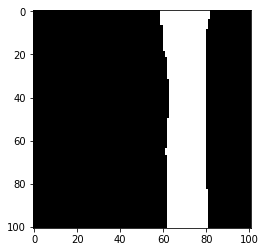

In [121]:
import cv2
def smooth_mask(_img, kernel_size=5):
    _img = _img*255
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erosion = cv2.erode(_img, kernel, iterations = 1)
    dilation = cv2.dilate(erosion, kernel, iterations = 1)
    return (dilation/255).astype(int)

_img = smooth_mask(img, kernel_size=9)

plt.imshow(_img, cmap='binary')